## SIR PriorCVAE Inference

This notebook generates Fig. 5, Fig. A26, Fig. A27.

In [1]:
import os
import yaml

import matplotlib.pyplot as plt
import numpy as np
import random
import scipy
import jax
from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey
import numpyro
import numpyro.distributions as npdist
from numpyro.infer import MCMC, NUTS, Predictive
import flax.linen as nn
import tikzplotlib

from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params, generate_decoder_samples
from priorCVAE.priors import SIR

In [2]:
N = 763
observed_data = jnp.array([3,8,26,76,225,298,258,233,189,128,68,29,14,4])
num_days = len(observed_data)
z_init = jnp.array([N - 1.0, 1.0, 0.0])

num_warmup = 1000
num_samples = 1000
num_chains = 1

model_path = "../../outputs/01-09-49/"

save_tex = True
output_tex = r"../../../../../papers/priorcvae/figures/SIR/"

## Fit model to the boarding school data

In R:

`library(outbreaks)`

`df = influenza_england_1978_school`

Priors for beta and gamma are borrowed from here:
    https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html#1_simple_sir

    beta ~ normal(2, 1); //truncated at 0
    gamma ~ normal(0.4, 0.5); //truncated at 0

In [3]:
def dz_dt(z, t, beta, gamma):
    """
    Susceptible-Infectious (SIS) model.
    """
    # Initial conditions
    S = z[0]
    I = z[1]
    R = z[2]

    #N = S + I + R
    # hardcode N!!! -> change this in the future
    N = 763

    dS_dt = -beta * I * S / N;
    dI_dt =  beta * I * S / N - gamma * I;
    dR_dt =  gamma * I;

    return jnp.stack([dS_dt, dI_dt, dR_dt])


In [4]:
def sir_model(num_days, z_init=None, beta=None, gamma=None, n_states=3, observed_data=None, 
          dist_beta  = npdist.TruncatedNormal(loc=2,  scale=1,low=0.),
          dist_gamma = npdist.TruncatedNormal(loc=0.4,scale=0.5,low=0.)
          ):

    # initial population
    if z_init is None:
        z_init = numpyro.sample("z_init", npdist.LogNormal(jnp.log(10), 1).expand([n_states]))

    # measurement times
    ts = jnp.arange(float(num_days))

    # parameters beta, gamma of dz_dt
    if beta is None:
        beta = numpyro.sample("beta", dist_beta)

    if gamma is None:
        gamma = numpyro.sample("gamma", dist_gamma)

    # integrate dz/dt, the result will have shape num_days x 2
    z = numpyro.deterministic("z", odeint(dz_dt, z_init, ts, beta, gamma, rtol=1e-6, atol=1e-5, mxstep=1000))

    phi_inv = numpyro.sample("phi_inv", npdist.Exponential(5))
    phi = numpyro.deterministic("phi", 1./phi_inv)

    # Likelihood
    #obs = numpyro.sample("observed", dist.Poisson(z[:, 1]), obs=observed_data)
    obs = numpyro.sample("observed", npdist.NegativeBinomial2(z[:, 1], phi), obs=observed_data)

## ODE - inference

In [5]:
# use dense_mass for better mixing rate
mcmc_ode = MCMC(
        NUTS(sir_model, dense_mass=True),
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )

In [6]:
mcmc_ode.run(rng_key=PRNGKey(18), num_days = num_days, z_init = z_init, observed_data=observed_data)

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 973.43it/s, 7 steps of size 5.63e-01. acc. prob=0.93]


In [7]:
mcmc_ode.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.06      0.08      2.05      1.94      2.17    495.32      1.01
     gamma      0.51      0.04      0.51      0.44      0.57    620.12      1.01
   phi_inv      0.11      0.07      0.10      0.02      0.21    573.67      1.00

Number of divergences: 0


In [8]:
# Get posterior samples
posterior_samples_ode = mcmc_ode.get_samples()

In [9]:
# posterior predictive
sir_posterior_predictive_ode = Predictive(sir_model, posterior_samples_ode)(PRNGKey(11), 
                                                                            num_days = num_days, z_init = z_init)
observed_posterior_predictive_ode = sir_posterior_predictive_ode['observed']
observed_posterior_mean_ode = observed_posterior_predictive_ode.mean(axis=0)
observed_posterior_25_ode = np.quantile(observed_posterior_predictive_ode, 0.05, axis=0)
observed_posterior_75_ode = np.quantile(observed_posterior_predictive_ode, 0.95, axis=0)

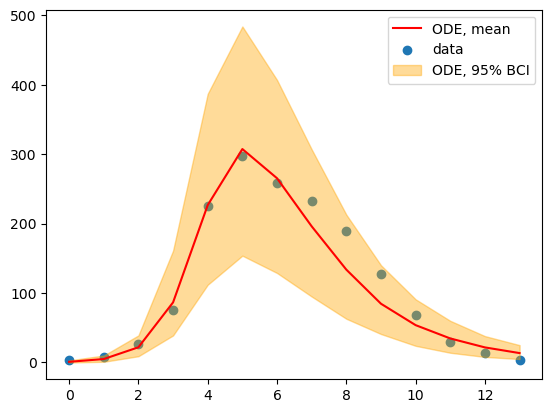

In [10]:
plt.scatter(range(num_days), observed_data, label='data')
plt.plot(range(num_days), observed_posterior_mean_ode, label="ODE, mean", color= "red")
plt.fill_between(range(num_days), observed_posterior_25_ode, observed_posterior_75_ode, alpha=0.4, interpolate=True, label="ODE, 95% BCI", color="orange")
plt.legend()

## Define model - PriorCVAE

In [11]:
cfg_path = os.path.join(model_path, ".hydra", "config.yaml")

with open(cfg_path, 'r') as file:
    cfg_data = yaml.safe_load(file)

latent_dim = cfg_data["latent_dim"]
conditional = cfg_data["conditional"]
dec_activation_fn = cfg_data["dec_activation"]["_target_"]
dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])

trained_decoder_params = load_model_params(os.path.join(model_path, "model"))["decoder"]

output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

In [12]:
def priorcvae_model(num_days, z_init=None, beta=None, gamma=None, n_states=3, observed_data=None,
          latent_dim = latent_dim,
          dist_beta  = npdist.TruncatedNormal(loc=2,  scale=1,low=0.),
          dist_gamma = npdist.TruncatedNormal(loc=0.4,scale=0.5,low=0.)):
    # measurement times
    ts = jnp.arange(float(num_days))

    # parameters beta, gamma of dz_dt
    if beta is None:
        beta = numpyro.sample("beta", dist_beta)

    if gamma is None:
        gamma = numpyro.sample("gamma", dist_gamma)

    c = jnp.array([beta, gamma]).reshape((2, ))

    z = numpyro.sample("z", npdist.Normal(jnp.zeros(latent_dim), jnp.ones(latent_dim)))
    z = jnp.concatenate([z, c]) 
    #z = z.reshape((1, -1))

    N = 763
    f = decoder.apply({'params': trained_decoder_params}, z)
    f = numpyro.deterministic("infected", nn.sigmoid(f) * N)  # Last layer activation
    
    phi_inv = numpyro.sample("phi_inv", npdist.Exponential(5))
    phi = numpyro.deterministic("phi", 1./phi_inv);

    # Likelihood
    obs = numpyro.sample("observed", npdist.NegativeBinomial2(f, phi), obs=observed_data)

## Inference - PriorCVAE

In [13]:
# use dense_mass for better mixing rate
mcmc_cvae = MCMC(
        NUTS(priorcvae_model, dense_mass=True),
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )

In [14]:
mcmc_cvae.run(rng_key=PRNGKey(11),
         num_days = num_days,
         z_init = z_init,
         observed_data=observed_data)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1377.36it/s, 7 steps of size 4.81e-01. acc. prob=0.90]


In [15]:
mcmc_cvae.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.39      0.24      2.39      2.02      2.79    603.57      1.00
     gamma      0.65      0.16      0.66      0.37      0.90    483.50      1.00
   phi_inv      0.20      0.11      0.17      0.05      0.34    758.71      1.00
      z[0]      0.03      0.87      0.02     -1.35      1.50    541.05      1.00
      z[1]     -0.03      0.79     -0.04     -1.32      1.23    864.68      1.00
      z[2]      0.04      1.00      0.02     -1.52      1.70   1097.28      1.00
      z[3]      0.02      1.00      0.02     -1.49      1.79   1256.76      1.00
      z[4]      0.00      0.98      0.00     -1.49      1.64   1472.82      1.00
      z[5]      0.00      0.98      0.03     -1.56      1.60   1329.89      1.00

Number of divergences: 2


In [16]:
# Get posterior samples
posterior_samples_vae = mcmc_cvae.get_samples()

In [17]:
# posterior predictive
sir_posterior_predictive_vae = Predictive(priorcvae_model, posterior_samples_vae)(PRNGKey(11), 
                                                                                  num_days = num_days, 
                                                                                  z_init = z_init)
observed_posterior_predictive_vae = sir_posterior_predictive_vae['observed']
observed_posterior_mean_vae = observed_posterior_predictive_vae.mean(axis=0)
observed_posterior_25_vae = np.quantile(observed_posterior_predictive_vae, 0.05, axis=0)
observed_posterior_75_vae = np.quantile(observed_posterior_predictive_vae, 0.95, axis=0)

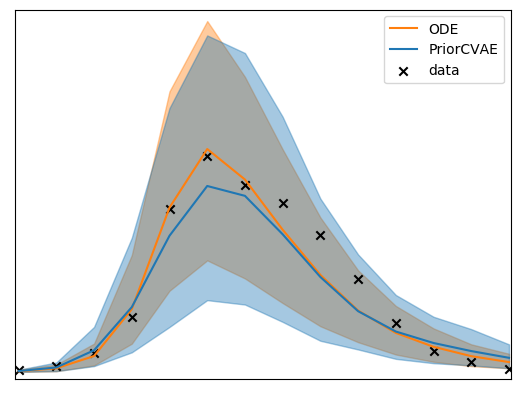

In [37]:
plt.plot(range(num_days), observed_posterior_mean_ode, label="ODE", color= "tab:orange")
plt.fill_between(range(num_days), observed_posterior_25_ode, observed_posterior_75_ode, alpha=0.4, 
                 interpolate=True, color="tab:orange")

plt.plot(range(num_days), observed_posterior_mean_vae[:,], label="PriorCVAE", color="tab:blue")
plt.fill_between(range(num_days), observed_posterior_25_vae[:,], observed_posterior_75_vae[:,], 
                 alpha=0.4, interpolate=True, color="tab:blue")

plt.scatter(range(num_days), observed_data, marker="x" ,label='data', c="black")

plt.xlim([-0.1, 13.05])
plt.ylim([-10, 500])
plt.xticks([])
plt.yticks([])

plt.legend()
plt.show()

In [19]:
mcmc_ode.print_summary()
mcmc_cvae.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.06      0.08      2.05      1.94      2.17    495.32      1.01
     gamma      0.51      0.04      0.51      0.44      0.57    620.12      1.01
   phi_inv      0.11      0.07      0.10      0.02      0.21    573.67      1.00

Number of divergences: 0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.39      0.24      2.39      2.02      2.79    603.57      1.00
     gamma      0.65      0.16      0.66      0.37      0.90    483.50      1.00
   phi_inv      0.20      0.11      0.17      0.05      0.34    758.71      1.00
      z[0]      0.03      0.87      0.02     -1.35      1.50    541.05      1.00
      z[1]     -0.03      0.79     -0.04     -1.32      1.23    864.68      1.00
      z[2]      0.04      1.00      0.02     -1.52      1.70   1097.28      1.00
      z[3]      0.02      1.00      0.02     -1.49      1.79   1256.76      1.00


In [20]:
beta_ode = posterior_samples_ode['beta']
beta_vae = posterior_samples_vae['beta']

gamma_ode = posterior_samples_ode['gamma']
gamma_vae = posterior_samples_vae['gamma']

phi_inv_ode = posterior_samples_ode['phi_inv']
phi_inv_vae = posterior_samples_vae['phi_inv']

In [21]:
# priors
sir_predictive = Predictive(priorcvae_model, num_samples=1000)
rng_key_draw = PRNGKey(18)
sir_sims = sir_predictive(rng_key=rng_key_draw, num_days = num_days, z_init = z_init)

beta_prior = sir_sims['beta']
gamma_prior = sir_sims['gamma']
phi_inv_prior = sir_sims['phi']

<Figure size 640x480 with 0 Axes>

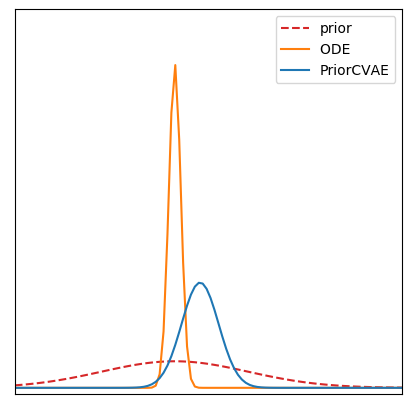

In [22]:
beta_prior_mean = np.mean(beta_prior)
beta_prior_sigma = np.std(beta_prior)

beta_ode_mean = np.mean(beta_ode)
beta_ode_sigma = np.std(beta_ode)

beta_vae_mean = np.mean(beta_vae)
beta_vae_sigma = np.std(beta_vae)

x_tmp = np.linspace(-0.001, 5, 100)

plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, beta_prior_mean, beta_prior_sigma), label=r'Prior', c="tab:red", 
        linestyle="dashed")
plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, beta_ode_mean, beta_ode_sigma), label=r'ODE ', c="tab:orange")
plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, beta_vae_mean, beta_vae_sigma), label=r'PriorCVAE', c="tab:blue")

plt.xlim([0, 5])
plt.ylim([-0.1, 6])
plt.xticks([])
plt.yticks([])

plt.legend()

output_tik_path = os.path.join(output_tex, r"SIR_beta_posterior.tex")
tikzplotlib.save(output_tik_path,
                figurewidth='\\figurewidth', figureheight='\\figureheight')

<Figure size 640x480 with 0 Axes>

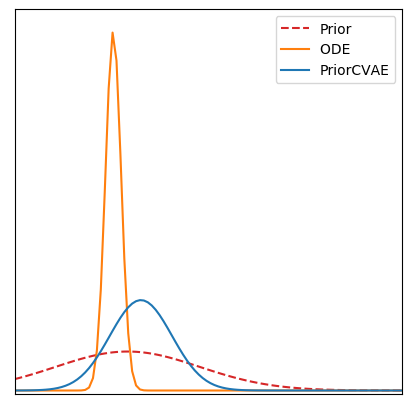

In [23]:
gamma_prior_mean = np.mean(gamma_prior)
gamma_prior_sigma = np.std(gamma_prior)

gamma_ode_mean = np.mean(gamma_ode)
gamma_ode_sigma = np.std(gamma_ode)

gamma_vae_mean = np.mean(gamma_vae)
gamma_vae_sigma = np.std(gamma_vae)

x_tmp = np.linspace(-0.001, 2, 100)

plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, gamma_prior_mean, gamma_prior_sigma), label=r'Prior', c="tab:red", 
         linestyle="dashed")
plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, gamma_ode_mean,   gamma_ode_sigma),   label=r'ODE ', c="tab:orange")
plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, gamma_vae_mean,   gamma_vae_sigma),   label=r'PriorCVAE', c="tab:blue")

plt.xlim([0, 2])
plt.ylim([-0.1, 10.5])
plt.xticks([])
plt.yticks([])

plt.legend()

output_tik_path = os.path.join(output_tex, r"SIR_gamma_posterior.tex")
tikzplotlib.save(output_tik_path,
                figurewidth='\\figurewidth', figureheight='\\figureheight')